<a href="https://colab.research.google.com/github/artbogdanovai/fast_aicourse/blob/master/course/rice/adding_timm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trying to solve rice competiton
In pure pytorch instead of fast ai

In [57]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [58]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [59]:
!pip install fastai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [60]:
import os
import pathlib
import zipfile
import glob
import fastai
from PIL import Image
import pandas as pd
import timm
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [61]:
comp = 'paddy-disease-classification'


In [62]:
creds = '{"username":"artbogdanov","key":"c896dcbee655a8f2bf17e34fc875f65b"}'

In [63]:
if not os.path.exists(os.path.expanduser('~')+'/.kaggle'):
  os.makedirs(os.path.expanduser('~')+'/.kaggle')

In [64]:
with open(os.path.expanduser('~')+'/.kaggle/kaggle.json', 'w') as f:
    f.write(creds)

In [65]:
import kaggle

In [66]:
!ls 

paddy-disease-classification  paddy-disease-classification.zip	sample_data


In [67]:
path = pathlib.Path(comp)

In [68]:
if not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

In [69]:
example = glob.glob(str(path)+'/train_images/downy_mildew/*')[5]

In [70]:
im = Image.open(example)

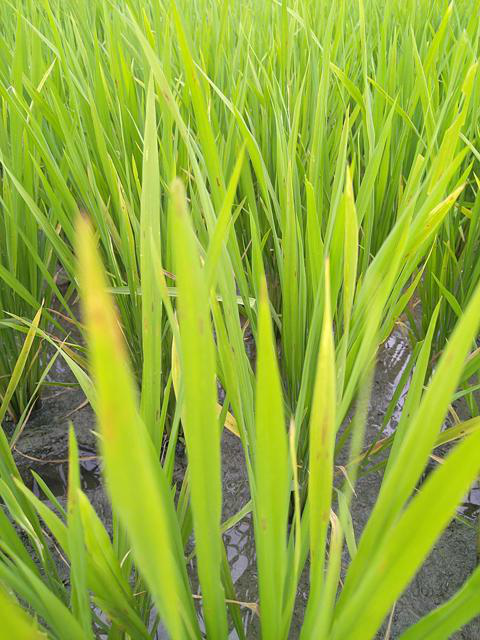

In [71]:
im

In [72]:
if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev) 
device

device(type='cuda', index=0)

In [89]:
side_size=480

In [90]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize([side_size,side_size]),
     ])
#transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

In [91]:
dataset = torchvision.datasets.ImageFolder(comp+'/train_images',transform)

In [92]:
dataset

Dataset ImageFolder
    Number of datapoints: 10407
    Root location: paddy-disease-classification/train_images
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=[480, 480], interpolation=bilinear, max_size=None, antialias=None)
           )

In [93]:
train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(
    dataset, [train_size, valid_size], 
    generator=torch.Generator().manual_seed(42))

In [94]:
batch_size=16

In [95]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

In [96]:
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size,
                                          shuffle=True)

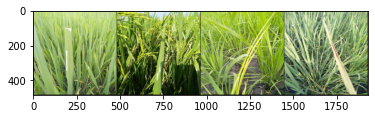

In [97]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
plt.imshow(np.transpose(torchvision.utils.make_grid(images[0:4]), (1, 2, 0)))
plt.show()

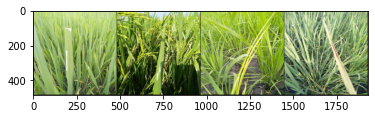

In [98]:
plt.imshow(np.transpose(torchvision.utils.make_grid(images[0:4]), (1, 2, 0)))
plt.show()


In [99]:
images[0].shape

torch.Size([3, 480, 480])

In [100]:
classes = dataset.classes
no_of_classes = len(classes)
classes

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [101]:
no_of_classes

10

In [102]:
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

hispa hispa tungro bacterial_leaf_blight


In [103]:
def calculate_test_accuracy(dataloader):
  total = 0
  correct = 0
  with torch.no_grad():
      for data in dataloader:
          images, labels = data[0].to(device), data[1].to(device)
          # calculate outputs by running images through the network
          outputs = net(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f'Accuracy of the network: {100 * correct // total} %')

In [48]:
# import torch.nn as nn
# import torch.nn.functional as F




# class Net(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 8, 3, padding=1)
#         self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
#         self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
#         self.fc = nn.Linear(32*15*15, 10)
        
#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         x = F.max_pool2d(x, 2)
#         x = F.relu(self.conv2(x))
#         x = F.max_pool2d(x, 2)
#         x = F.relu(self.conv3(x))
#         x = F.max_pool2d(x, 2)
#         x = torch.flatten(x,1)
#         #print(x.shape)
#         x = self.fc(x)
#         return x

# net = Net()
# net = net.to(device)

In [105]:
net = timm.create_model('resnet34', pretrained = True, num_classes=10)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet34-43635321.pth" to /root/.cache/torch/hub/checkpoints/resnet34-43635321.pth


In [110]:
net = net.to(device)

In [111]:
images.shape

torch.Size([16, 3, 480, 480])

In [112]:
net.forward(images.to(device)).shape

torch.Size([16, 10])

In [113]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [114]:
len(trainloader)

521

In [115]:
%%time
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    correct=0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        with torch.no_grad():
            _, preds = torch.max(outputs.data, 1)
            
            correct += (preds == labels).float().sum()
            #print(preds,labels,(preds == labels).float().sum(),correct)
        running_loss += loss.item()
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
    print(f'acc:{correct}, {len(trainloader)*batch_size}, {correct/(len(trainloader)*batch_size)}')
    calculate_test_accuracy(validloader)

print('Finished Training')

[1,   521] loss: 0.295
acc:5213.0, 8336, 0.6253598928451538
Accuracy of the network: 83 %
[2,   521] loss: 0.088
acc:7484.0, 8336, 0.8977926969528198
Accuracy of the network: 88 %
[3,   521] loss: 0.035
acc:8005.0, 8336, 0.9602926969528198
Accuracy of the network: 92 %
[4,   521] loss: 0.017
acc:8189.0, 8336, 0.982365608215332
Accuracy of the network: 93 %
[5,   521] loss: 0.011
acc:8247.0, 8336, 0.9893233776092529
Accuracy of the network: 94 %
[6,   521] loss: 0.005
acc:8292.0, 8336, 0.9947216510772705
Accuracy of the network: 93 %
[7,   521] loss: 0.007
acc:8279.0, 8336, 0.9931621551513672
Accuracy of the network: 94 %
[8,   521] loss: 0.005
acc:8292.0, 8336, 0.9947216510772705
Accuracy of the network: 94 %
[9,   521] loss: 0.003
acc:8306.0, 8336, 0.9964011311531067
Accuracy of the network: 94 %
[10,   521] loss: 0.003
acc:8300.0, 8336, 0.9956813454627991
Accuracy of the network: 94 %
Finished Training
CPU times: user 45min 27s, sys: 2min 5s, total: 47min 32s
Wall time: 47min 36s


In [54]:
%%time
calculate_test_accuracy(trainloader)


Accuracy of the network: 85 %
CPU times: user 1min 1s, sys: 496 ms, total: 1min 2s
Wall time: 1min 2s


In [55]:
%%time
calculate_test_accuracy(validloader)


Accuracy of the network: 72 %
CPU times: user 16.3 s, sys: 119 ms, total: 16.4 s
Wall time: 16.4 s


In [116]:
PATH = './timm_resnet.pth'
torch.save(net, PATH)

In [117]:
model = net

In [118]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [119]:
all_images = glob.glob('paddy-disease-classification/test_images/*')

In [120]:
results = pd.DataFrame(columns = ['image_id','label'])

In [121]:
i=0
for im in all_images:
    name = im.split('/')[-1]
    image = Image.open(im).convert("RGB")
    image = transform(image).to(device)
    image = image.reshape(1,3,480,480)
    with torch.no_grad():
        outputs = net(image)
    rice_class = dataset.classes[torch.max(outputs.data, 1)[1]]
    results.loc[len(results)] = [name,rice_class]
    i+=1
    if i%500 == 0:
      print(f'500 done {i}')

500 done 500
500 done 1000
500 done 1500
500 done 2000
500 done 2500
500 done 3000


In [123]:
results.to_csv('submission_timm.csv',index=False)